## **IMPORTS**

In [6]:
import Metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para fazer a NORMALIZAÇÃO
from sklearn.preprocessing import MinMaxScaler

# Biblioteca para calcular a acuracia do modelo
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

from imblearn.over_sampling import ADASYN
from collections import Counter

from scipy.stats import tukey_hsd
from scipy import stats

from sklearn.svm import OneClassSVM

## **LEITURA DOS DADOS**

In [7]:
#data = pd.read_csv('../Base de Dados/Dados_49_V.csv', na_values='?')

data = pd.read_csv('../Base de Dados/Dados_10_V_FISHER.csv', na_values='?')

print(data.shape)
data.head()

(2185, 11)


,inseminacao_2cat,total_animais_prop,teste_bruc,compra_repr,venda_repr,dest_leilao,vacina_semqqidade,piquete_parto,assist_vet,tipo_assist,resul_prop
0,0,15,0,0,0,0,0,0,0,-1,0
1,0,142,0,1,1,0,1,1,0,-1,0
2,0,40,0,1,1,0,-1,1,0,-1,0
3,0,68,0,1,0,0,1,0,0,-1,0
4,0,38,0,0,0,0,0,0,0,-1,0


In [8]:
# Gerando um DataFrame das variáveis preditoras originais SEM a variável TARGET
VAR_PREDITORAS_ORIG = data.drop('resul_prop', axis = 1)

# Gerando um DataFrame somente da variavel TARGET
VAR_TARGET = data['resul_prop']

## **NORMALIZAÇÃO**

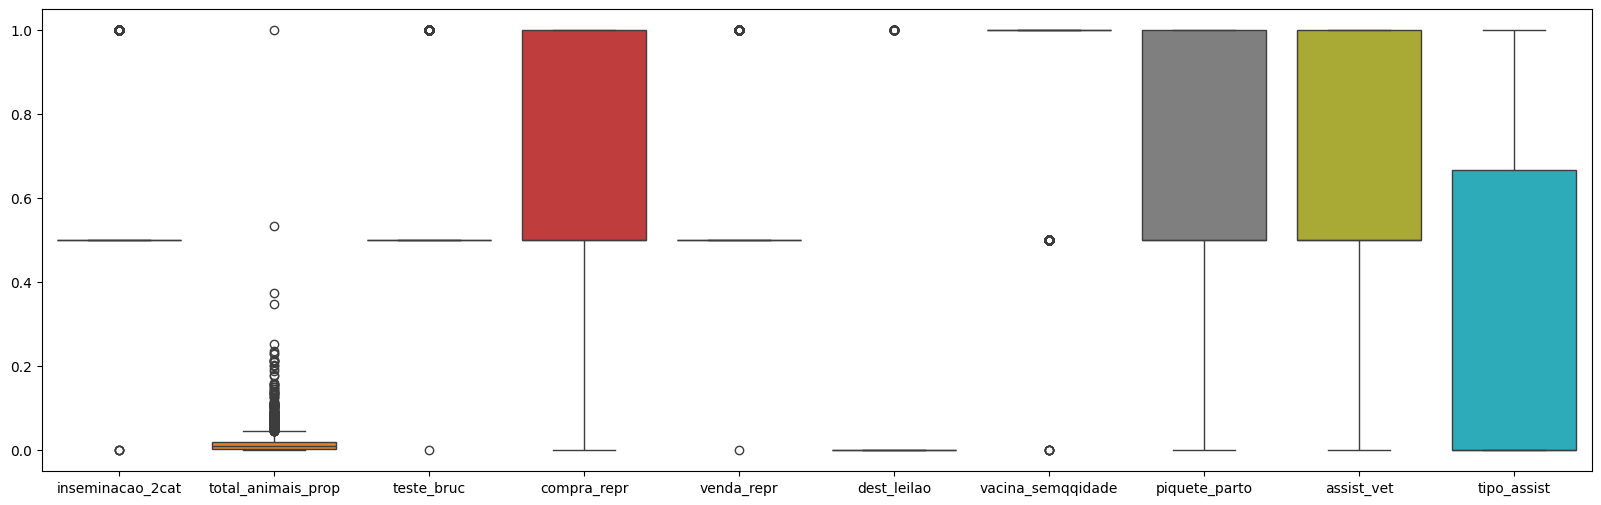

In [9]:
# Criando um objeto para NORMALIZAR os dados
obj_normalizacao = MinMaxScaler().fit(VAR_PREDITORAS_ORIG)

# Aplicando a NORMALIZAÇÃO
VAR_PREDITORAS_NORM = obj_normalizacao.transform(VAR_PREDITORAS_ORIG)

# Transformando para DataFrame e nomeando as colunas
VAR_PREDITORAS_NORM = pd.DataFrame(VAR_PREDITORAS_NORM)

VAR_PREDITORAS_NORM.columns = data.drop('resul_prop', axis = 1).columns

VAR_PREDITORAS_NORM

plt.figure(figsize=(20,6))
ax = sns.boxplot(data=VAR_PREDITORAS_NORM)

DATA_NORM = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET)
DATA_NORM_NEG = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 0').reset_index(drop=True)
DATA_NORM_POS = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 1').reset_index(drop=True)

## **SVM + Replicação**

In [10]:
metricas = pd.DataFrame()

num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS = pd.concat([DATA_NORM_POS.head(num_am_grupo_pos),DATA_NORM_POS.head(num_am_grupo_pos)], ignore_index = True)

    #-------------------------- TREINANDO SVM -------------------------------
    svm = OneClassSVM(gamma='auto', nu=0.45).fit(CLASSE_POS.drop('resul_prop', axis = 1).to_numpy())

    #-------------------------- TESTE SVM -------------------------------
    TEST_NEG = DATA_NORM_NEG

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = svm.predict(X_TEST.to_numpy())

    valores_preditos[valores_preditos == -1] = 0

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    #class_names = ['Negativo', 'Positivo']
    metricas = pd.concat([metricas, Metrics.cacule_metrics(Y_TEST,valores_preditos)], axis=0, ignore_index=True)

Metrics.save_metrics(metricas, "SVM_"+str(data.shape[1]-1)+"V_rep.csv")

print("FIM")

FIM


## **SVM + ADASYN**

In [12]:
metricas = pd.DataFrame()

num_am_grupo_pos = 60

for i in range (0,100):
    #-------------------------- ADASYN -------------------------------
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS_ADASYN = DATA_NORM_POS.head(num_am_grupo_pos)

    CLASSE_NEG_ADASYN = DATA_NORM_NEG

    X_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN.drop('resul_prop', axis = 1),
        CLASSE_POS_ADASYN.drop('resul_prop', axis = 1)]).reset_index(drop=True)

    Y_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN['resul_prop'],
        CLASSE_POS_ADASYN['resul_prop']]).reset_index(drop=True)

    ada = ADASYN(sampling_strategy=0.12, n_neighbors=6)

    X_RESAMPLING, Y_RESAMPLING = ada.fit_resample(X_ADASYN_ORIGINAL, Y_ADASYN_ORIGINAL)

    #-------------------------- TREINANDO SVM -------------------------------
    CLASSE_POS = X_RESAMPLING.assign(resul_prop=Y_RESAMPLING).query('resul_prop == 1').reset_index(drop=True)
    
    svm = OneClassSVM(gamma='auto', nu=0.45).fit(CLASSE_POS.drop('resul_prop', axis = 1).to_numpy())
    
    #-------------------------- TESTE SVM -------------------------------
    TEST_NEG = DATA_NORM_NEG
    
    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = svm.predict(X_TEST.to_numpy())

    valores_preditos[valores_preditos == -1] = 0

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    #class_names = ['Negativo', 'Positivo']
    metricas = pd.concat([metricas, Metrics.cacule_metrics(Y_TEST,valores_preditos)], axis=0, ignore_index=True)

Metrics.save_metrics(metricas, "SVM_"+str(data.shape[1]-1)+"V_adasyn.csv")

print("FIM")

FIM


## **SVM CONTROLE**

In [14]:
metricas = pd.DataFrame()

num_am_grupo_pos = 60

for i in range (0,100):
    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS = DATA_NORM_POS.head(num_am_grupo_pos)

    #-------------------------- TREINANDO SVM -------------------------------
    svm = OneClassSVM(gamma='auto', nu=0.45).fit(CLASSE_POS.drop('resul_prop', axis = 1).to_numpy())

    #-------------------------- TESTE SVM -------------------------------
    TEST_NEG = DATA_NORM_NEG

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']
    valores_preditos = svm.predict(X_TEST.to_numpy())

    valores_preditos[valores_preditos == -1] = 0

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    #class_names = ['Negativo', 'Positivo']
    metricas = pd.concat([metricas, Metrics.cacule_metrics(Y_TEST,valores_preditos)], axis=0, ignore_index=True)

Metrics.save_metrics(metricas, "SVM_"+str(data.shape[1]-1)+"V_contr.csv")

print("FIM")

FIM
